In [ ]:
:extension DerivingVia TypeFamilies DerivingStrategies GeneralizedNewtypeDeriving FlexibleContexts OverloadedStrings

import Diagrams.Prelude
import Control.Monad ((>=>))
import Data.Bifunctor (second)
import Data.Tuple (swap)
import Data.String (IsString)
import Data.Maybe (fromMaybe)
import IHaskell.Display.Diagrams
import Diagrams.Backend.Cairo (B)
import Data.Tree (Tree(Node), Forest, rootLabel, subForest, drawForest)

### Type definitions

In [ ]:
newtype Location = Location { name :: String } deriving newtype (Eq, Show, IsString)

data BellPair = Location :~: Location

instance Show BellPair where
    show (l1 :~: l2) = name l1 <> "," <> name l2
instance Eq BellPair where
    l1 :~: l2 == l1' :~: l2' = (l1 , l2) == (l1', l2') || (l2, l1) == (l1', l2') 

newtype History = History { getForest :: Forest BellPair } deriving newtype (Show, Semigroup, Monoid) 

newtype Policy = Policy (History -> History) deriving (Monoid, Semigroup) via (Dual (Endo History))

### Auxiliary functions

In [ ]:
findTreeRoot :: BellPair -> [Tree BellPair] -> Maybe (Tree BellPair, [Tree BellPair])
findTreeRoot p [] = Nothing
findTreeRoot p (t : ts) | rootLabel t == p = Just (t, ts)
                        | otherwise = second (t :) <$> findTreeRoot p ts

### Main policy definitions

In [ ]:
create :: Location -> Policy
create l = Policy $ \h -> History [Node (l :~: l) []] <> h

swap :: Location -> (Location, Location) -> Policy
swap l (l1, l2) = Policy $ \(History ts) -> fromMaybe (History []) $
    findTreeRoot (l :~: l1) ts >>= \(t, ts) ->
        findTreeRoot (l :~: l2) ts >>= \(t', ts) ->
            return $ History [Node (l1 :~: l2) [t, t']]
            
transmit :: Location -> (Location, Location) -> Policy
transmit l (l1, l2) = Policy $ \(History ts) -> fromMaybe (History []) $
    findTreeRoot (l :~: l) ts >>= \(t, ts) ->
        return $ History [Node (l1 :~: l2) [t]]
            
distill :: Location -> Location -> Policy
distill l1 l2 = Policy $ \(History ts) -> fromMaybe (History []) $
    findTreeRoot (l1 :~: l2) ts >>= \(t, ts) ->
        findTreeRoot (l1 :~: l2) ts >>= \(t', ts) ->
            return $ History [Node (l1 :~: l2) [t, t']]
            
identity :: Location -> Location -> Policy
identity l1 l2 = Policy $ \(History ts) -> fromMaybe (History []) $
    findTreeRoot (l1 :~: l2) ts >>= \(t, ts) ->
        return $ History [Node (l1 :~: l2) [t]]            

(-*-) :: Policy -> Policy -> Policy
(-*-) = (<>)

(-+-) :: Policy -> Policy -> Policy
(Policy f) -+- (Policy g) = Policy $ \h -> f h <> g h

(-$-) :: Policy -> History -> History
(Policy f) -$- h = f h 

### Some drawing code

In [ ]:
pairToDiagram bp = (text (show bp) <> rect 4 1) # fontSize (local 0.5) 

treeToDiagram t = 
    let childrenNames = [1..(length $ subForest t :: Int)]
        rootName = 0 :: Int
        subtrees = zipWith (.>>) childrenNames (map treeToDiagram $ subForest t)
      in vsep 1 [pairToDiagram (rootLabel t) # named rootName, hsep 0.5 subtrees # centerX  ] 
          # appEndo (mconcat $ map (\i -> Endo $ connectOutside (i .> rootName) rootName) childrenNames)

historyToDiagram (History ts) = hsep 0.5 (map treeToDiagram ts)

drawPolicy :: Policy -> ManuallySized (Diagram B)
drawPolicy p = withImgWidth 600 . historyToDiagram $ p -$- History [] 

drawPolicyText :: Policy -> IO ()
drawPolicyText p = putStrLn . drawForest . (fmap . fmap) show . getForest $ p -$- History []

## Examples

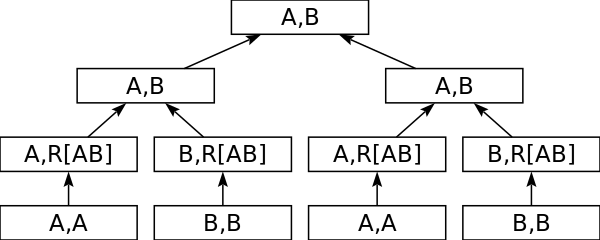

In [ ]:
p = (create "A" -+- create "B") -*- (transmit "A" ("A", "R[AB]") -+- transmit "B" ("B", "R[AB]")) -*- swap "R[AB]" ("A", "B")
    
drawPolicy $ (p -+- p) -*- distill "A" "B"

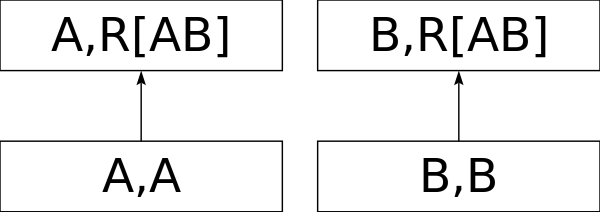

In [ ]:
drawPolicy $ (create "A" -+- create "B") -*- (transmit "A" ("A", "R[AB]") -+- transmit "B" ("B", "R[AB]"))

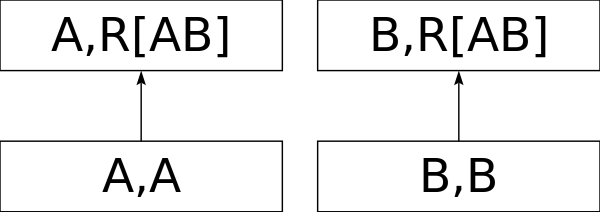

In [ ]:
drawPolicy $ 
    (create "A" -*- transmit "A" ("A", "R[AB]")) 
    -+- (create "B" -*- transmit "A" ("A", "R[AB]")) 
    -+- (create "A" -*- transmit "B" ("B", "R[AB]"))
    -+- (create "B" -*- transmit "B" ("B", "R[AB]"))

In [ ]:
drawPolicy $ 
    (create "A" -+- create "B") -*- transmit "A" ("A", "R[AB]") -*- transmit "B" ("B", "R[AB]")

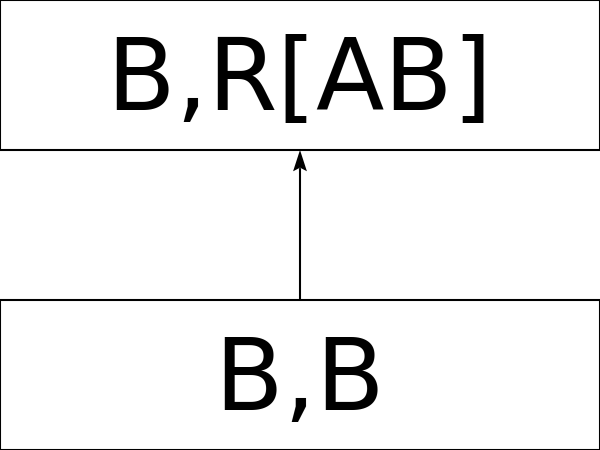

In [ ]:
drawPolicy $ 
    (create "A" -+- create "B") -*- (transmit "A" ("A", "R[AB]") -+- mempty) -*- transmit "B" ("B", "R[AB]")

## mempty acting on history, identity acting on (l1, l2) 

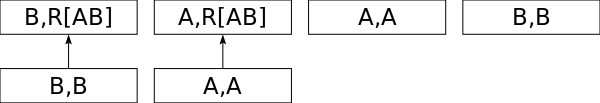

In [ ]:
drawPolicy $ 
    (create "A" -+- create "B") -*- (transmit "A" ("A", "R[AB]") -+- mempty) -*- (transmit "B" ("B", "R[AB]")-+- mempty)

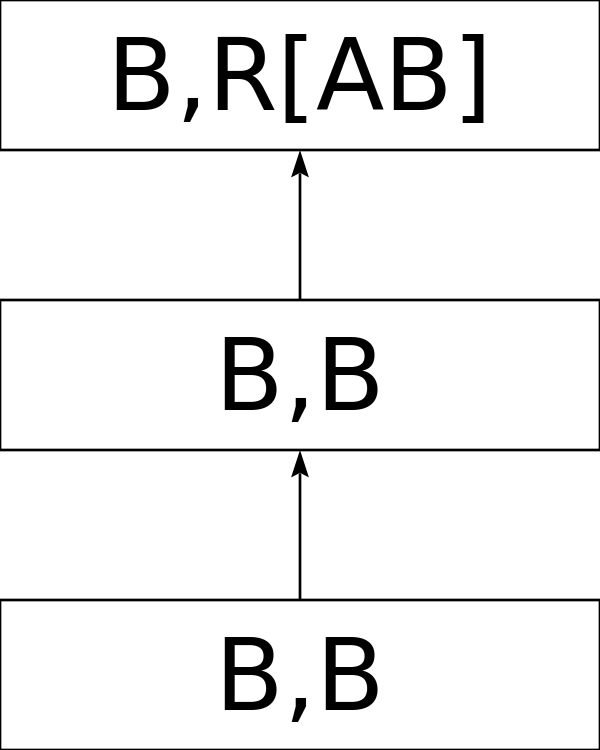

In [ ]:
drawPolicy $ 
    (create "A" -+- create "B") -*- (transmit "A" ("A", "R[AB]") -+- identity "B" "B") -*- transmit "B" ("B", "R[AB]")

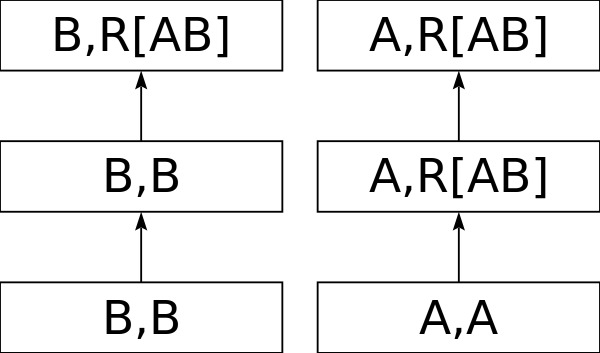

In [ ]:
drawPolicy $ 
    (create "A" -+- create "B") -*- (transmit "A" ("A", "R[AB]") -+- identity "B" "B") -*- (transmit "B" ("B", "R[AB]") -+- identity "A" "R[AB]")

In [ ]:
drawPolicyText p

A,B
|
+- A,R[AB]
|  |
|  `- A,A
|
`- B,R[AB]
   |
   `- B,B